In [1]:
### testing image registration functions
import numpy as np
from urllib.parse import urlparse
from cellpose import utils, io,models
import matplotlib
import matplotlib.pyplot as plt
import time, os, sys
import pandas as pd
import glob
### Part 1 : Image Registration
from skimage import img_as_uint,io,registration,transform,filters,restoration,util,feature,morphology,exposure,measure,segmentation
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from skimage.util import montage
from skimage.transform import warp_polar, rotate, rescale
from scipy.spatial import Voronoi
from skimage.feature import peak_local_max

from sklearn.cluster import KMeans

matplotlib.use('agg')


In [112]:
seg_file = "../images_2/1_dapi_seg.npy"



In [113]:
im = np.zeros_like(np.array(masks))
voro_imfile = "voro_temp.png"
max_voro_area = 2000
voro_outfile = "voro_final.npy"
voro_imfile_2 = "voro_final.tif"
voro_transfile = "voro.csv"

In [114]:
matplotlib.use('agg')

temp = np.asarray(np.load(seg_file,allow_pickle=True)).item()
masks = temp['masks']

im = np.zeros_like(np.array(masks))

fro = pd.DataFrame(measure.regionprops_table(masks, properties=['label','centroid']))


points_mask = np.array(fro[['centroid-0','centroid-1']].to_numpy())

vor = Voronoi(points_mask)

my_dpi=im.shape[1]

plt.rcParams['figure.dpi'] = my_dpi
plt.rcParams['figure.figsize'] = ( im.shape[0]/my_dpi,im.shape[1]/my_dpi)
fig = plt.figure();

for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    if np.all(simplex >= 0):
        plt.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k-',c='black',linewidth=.2)

center = points_mask.mean(axis=0)
for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
    simplex = np.asarray(simplex)
    if np.any(simplex < 0):
        i = simplex[simplex >= 0][0] # finite end Voronoi vertex
        t = points_mask[pointidx[0]] - points_mask[pointidx[1]]  # tangent
        t = t / np.linalg.norm(t)
        n = np.array([-t[1], t[0]]) # normal
        midpoint = points_mask[pointidx].mean(axis=0)
        far_point = vor.vertices[i] + np.sign(np.dot(midpoint - center, n)) * n * 100
        plt.plot([vor.vertices[i,0], far_point[0]],
                 [vor.vertices[i,1], far_point[1]], 'k-',c='black',linewidth=.2)

plt.xlim([0, im.shape[0]]); plt.ylim([0,im.shape[1]])
plt.axis('off')
fig.tight_layout(pad=0)
plt.savefig(voro_imfile, dpi=my_dpi, #bbox_inches='tight',#dpi=my_dpi,
            transparent=False, pad_inches=0,facecolor='white')
plt.close()
im2 = io.imread(voro_imfile)
voro = (im2[:,:,0])
voro = voro[1:-1, 1:-1]
voro = np.pad(voro, pad_width=1, mode='constant')
print('hey')
distance = ndi.distance_transform_edt(voro)
coords = peak_local_max(distance, footprint=np.ones((1, 1)), labels=voro)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = segmentation.watershed(-distance, markers, mask=voro)
labels = morphology.remove_small_objects(labels, min_size=40, connectivity=1, in_place=False)
labels = morphology.dilation(labels, morphology.square(3))
print('hey2')
segmasks = masks
segmasks = morphology.dilation(segmasks,morphology.square(3))

sizeOfSegs = pd.DataFrame(measure.regionprops_table(labels, properties=['label','area']))
bigMasks = np.array(sizeOfSegs[sizeOfSegs['area']>=max_voro_area]['label'])
print('hey3')
newVorMask = np.copy(labels)[::-1,:]


hey
hey2
hey3


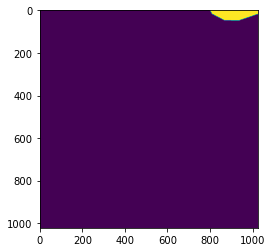

In [58]:
plt.imshow(tVorMask==fro['VorLabel'][0])

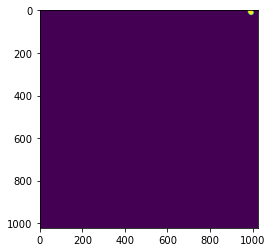

In [59]:
plt.imshow(segmasks==fro['label'][0])

In [115]:
def getOverlap(index, dilation=9):
    joint = segmentation.join_segmentations(morphology.dilation((segmasks==fro['label'][index]).astype(int),morphology.disk(dilation)),
                                          (tVorMask==fro['VorLabel'][index]).astype(int))
    final = (joint==np.max(joint))*fro.loc[index,'label']
    return(final)
    

In [116]:
startTime = time.time()
red =[getOverlap(row, dilation=11) for row in range(fro.shape[0])]
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

KeyError: 'VorLabel'

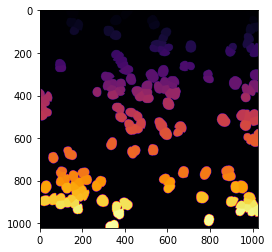

In [111]:
plt.imshow(sum(red),cmap='inferno')

In [108]:
12000/60/60

3.3333333333333335

In [64]:
(segmasks==fro['label'][0]).astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [55]:
tVorMask = newVorMask.T
fro['VorLabel'] = [(tVorMask[fro['centroid-0'].astype(int)[num],fro['centroid-1'].astype(int)[num]]) for num in range(fro.shape[0])]




160

In [ ]:
for bMI in range(len(bigMasks)):
    print("progress:"+str(bMI)+'/'+str(len(bigMasks)))
    chckMtx = (labels == bigMasks[bMI])[::-1,:]

    for i in range(len(points_mask)):
        confirm = points_mask[i]
        print(points_mask[i])
        print("---")

    tmp_cellpose_mask = (morphology.dilation((segmasks == int(fro[(fro['centroid-0']==confirm[0])&(fro['centroid-1']==confirm[1])]['label'])).T,morphology.disk(11))).astype(int)
    tmp_voronoi_mask = 2*chckMtx.astype(int)
    tmp_join = segmentation.join_segmentations(tmp_cellpose_mask,tmp_voronoi_mask)
    tmp_join = (tmp_join == np.max(tmp_join))

    newVorMask[newVorMask == bigMasks[bMI]] = 0
    newVorMask[tmp_join] = bigMasks[bMI]

np.save(voro_outfile, newVorMask.T, allow_pickle=True, fix_imports=True)
io.imsave(voro_imfile_2, segmentation.find_boundaries(newVorMask).T)

oldAssign = pd.DataFrame(measure.regionprops_table(masks, properties=['label','centroid']))
newAssign = pd.DataFrame(measure.regionprops_table(newVorMask, properties=['label','centroid']))

Clps2Voro = pd.DataFrame()

for nlab in range(newAssign.shape[0]):
    tmpMtx = (newVorMask == newAssign['label'][nlab])
    for olab in range(oldAssign.shape[0]):
        if (tmpMtx[int(np.round(oldAssign['centroid-1'][olab])),int(np.round(oldAssign['centroid-0'][olab]))]):
            Clps2Voro = Clps2Voro.append(pd.DataFrame([newAssign['label'][nlab], oldAssign['label'][olab]]).T)

Clps2Voro = Clps2Voro.rename(columns={0: "voro_label", 1: "clps_label"})
Clps2Voro = Clps2Voro.reset_index(drop=True)
Clps2Voro.to_csv(voro_transfile)

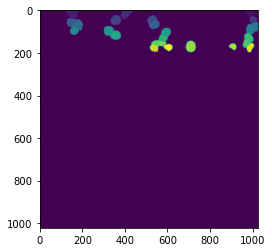

In [79]:
 %matplotlib inline
plt.imshow(complete)

In [23]:
io.imsave(voro_imfile_2, segmentation.find_boundaries(newVorMask).T)


/Users/pburnham/miniconda3/envs/unet2DE/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: voro_final.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  """Entry point for launching an IPython kernel.


In [25]:
points_mask_2 = np.asarray(np.load(voro_outfile,allow_pickle=True)).item()
#masks = temp['masks']


ValueError: can only convert an array of size 1 to a Python scalar

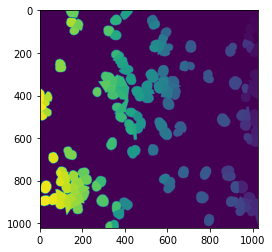

In [34]:
%matplotlib inline
plt.imshow(np.load(voro_outfile,allow_pickle=True).T)

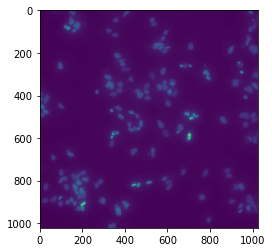

In [33]:
plt.imshow(io.imread('images/plate1_scan4_fov40_dapi.TIF'))

In [11]:
import glob
jpgFilenamesList = glob.glob('../images/*_dapi.TIF')
["_".join(sub.split('/')[-1].split('_')[:-1]) for sub in jpgFilenamesList] 


['plate1_scan2_fov10', 'plate1_scan4_fov40']